In [1]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


'\nPurpose: To run the soma splitting \non the processed neurons\n\n'

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

import datajoint_utils as du
from importlib import reload

INFO - 2021-01-13 15:35:13,866 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-13 15:35:13,868 - settings - Setting database.user to celiib
INFO - 2021-01-13 15:35:13,868 - settings - Setting database.password to newceliipass
INFO - 2021-01-13 15:35:13,874 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-13 15:35:13,875 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-13 15:35:13,887 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-13 15:35:14,137 - settings - Setting enable_python_native_blobs to True


In [3]:
test_mode = True

In [4]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-13 15:35:14,196 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-13 15:35:14,196 - settings - Setting database.user to celiib
INFO - 2021-01-13 15:35:14,197 - settings - Setting database.password to newceliipass
INFO - 2021-01-13 15:35:14,199 - settings - Setting enable_python_native_blobs to True


Sleeping 154 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-13 15:35:14,453 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [5]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [6]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 534


In [7]:
#so that it will have the adapter defined
from datajoint_utils import *

In [8]:
key_source = minnie.Decomposition()
key_source

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),multiplicity the number of somas found for this base segment,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134947393276,0,0.25,29.00,0,0,1,=BLOB=,1400375,2824255,0,0,0,0,1,8,185,95,7813492.355591639,3676864.0708675147,27015.716,77.107,77.107,491.082,454.082,2129,0.0002724773895089825,11.508108108108107,3947980.024,70,0.0005392631135562199,30.414,217783493374.38446,59995177.73949442,27872.746713386125,55163.271356609184,3111192762.4912066,1455.6467
864691135012905110,0,0.25,29.00,0,0,1,=BLOB=,816541,1676641,0,1,1,0,1,11,251,106,9668645.374834057,3910789.1103980723,24484.065,87.846,87.846,377.57,360.525,2129,0.0002201963064589635,8.48207171314741,5024192.766,95,0.0004237496647038483,22.411,387684463243.85925,100390791.9785207,40097.08167112429,77163.53279026621,4080889086.777466,1999.7675
864691135065018692,0,0.25,29.00,0,0,1,=BLOB=,927599,1896021,0,3,3,1,2,19,275,62,10132292.236507235,2065737.434988684,17292.299,110.528,110.528,545.626,544.758,2022,0.00019955997643994288,7.352727272727273,5469042.445,122,0.0003697173719777192,16.574,270764755455.50858,71119038.51464462,26722.95164167566,49508.62206290823,2219383241.438595,3221.0944
864691135065024068,0,0.25,29.00,0,0,1,=BLOB=,1683573,3378174,0,2,2,0,1,11,341,101,15436156.56531248,4728701.448726788,29394.698,311.757,282.738,609.362,594.189,4971,0.00032203612207268187,14.577712609970675,12419519.814,240,0.00040025702075827455,20.712,539357389298.1111,63617255.66268921,34941.17120515178,43428.199912376345,2247322455.4087963,6815.4656
864691135065033540,0,0.25,29.00,0,0,1,=BLOB=,788810,1618020,0,2,2,1,2,7,202,142,7316260.375838028,4091724.4008084666,21512.089,103.41,103.41,416.992,381.352,2199,0.0003005633871727972,10.886138613861386,3494175.925,84,0.0006293329377798859,26.179,450362108267.2257,122117801.5433146,61556.3259277305,128889.36273786092,5361453669.847925,1706.8981
864691135210051520,0,0.25,29.00,0,0,1,=BLOB=,498916,1023655,0,1,1,0,1,13,162,65,6094179.568630371,2578115.586153359,19166.911,95.1

In [9]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

    key_source = minnie.Decomposition()
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [10]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table)# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__neuron_split_suggestions,008c4d22e8e4c9b8eea4676f09706640,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,26948,35067,2021-01-13 03:34:10
__neuron_split_suggestions,1e759e336b7fd0f8b6b150213aba454d,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,8744,35479,2021-01-13 09:35:01
__neuron_split_suggestions,3231c2b8558606a7b2429fedd34acd41,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,8681,35478,2021-01-13 09:34:54
__neuron_split_suggestions,e9cc3e87e657666495518ed6b4272501,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,8807,35480,2021-01-13 09:35:08


INFO - 2021-01-13 15:35:14,742 - autopopulate - Found 55 keys to populate
INFO - 2021-01-13 15:35:14,752 - connection - Transaction started
INFO - 2021-01-13 15:35:14,753 - autopopulate - Populating: {'segment_id': 864691135609477127, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('29.00'), 'process_version': 0, 'index': 0}


Populate Started


----- Working on Neuron 864691135609477127-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [0 1]
multi_touch_limbs = [0]


 -------- Working on limb 0------------
Starting combinations to process = [[ 17  80]
 [ 17 110]
 [ 17 152]
 [ 80 110]
 [ 80 152]
 [110 152]]


---- working on disconnecting 17 and 80
---- This disconnects S1_0 from S0_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [17, 18, 21, 43, 66, 73, 80]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [ 1 16 18 19 21 22 41 43 49 53 56 66 72 73]
Short segments to combine = []
Found 2 high degree coordinates to cut
Picking [1002290.  475694.  734153.] high degree coordinates to cut
curr_limb.deleted_edges 4=[]
***inside resolve crossover!!!!****
coordinat

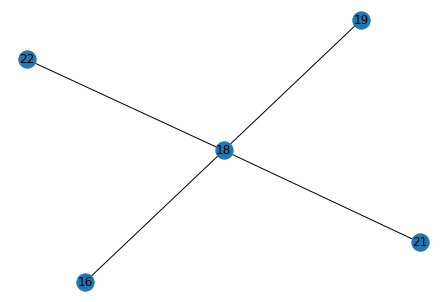

match_branches = [[18, 19], [16, 21]]
edges_to_delete (resolve crossover) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create (resolve crossover) = [[18, 19], [16, 21]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create = [[18, 19], [16, 21]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 27, 28, 30, 31, 33, 34, 36, 37, 40, 42, 44, 46, 47, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 71, 78, 79, 82, 83, 84, 87, 90, 91, 96, 97, 101, 102.0, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 140, 141, 147, 149, 158, 159, 160, 161, 162, 163, 164, 165, 174}
Comp 1 = {133, 134, 135, 136, 137, 138, 139, 142, 143, 16, 144, 146, 145, 148, 21, 150, 151, 152, 25, 154, 155, 26,

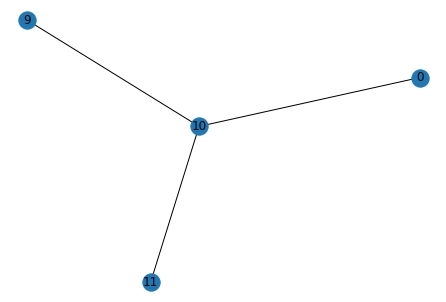

match_branches = [[0, 11], [9, 10]]
edges_to_delete (resolve crossover) = [[0, 9], [0, 10], [9, 11], [10, 11]]
edges_to_create (resolve crossover) = [[0, 11], [9, 10]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 9], [0, 10], [9, 11], [10, 11]]
edges_to_create = [[0, 11], [9, 10]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 27, 28, 30, 31, 33, 34, 36, 37, 40, 42, 44, 46, 47, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 71, 78, 79, 82, 83, 84, 87, 90, 91, 96, 97, 101, 102.0, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 140, 141, 147, 149, 158, 159, 160, 161, 162, 163, 164, 165, 174}
Comp 1 = {133, 134, 135, 136, 137, 138, 139, 142, 143, 16, 144, 146, 145, 148, 21, 150, 151, 152, 25, 154, 155, 26, 29, 157, 153, 3

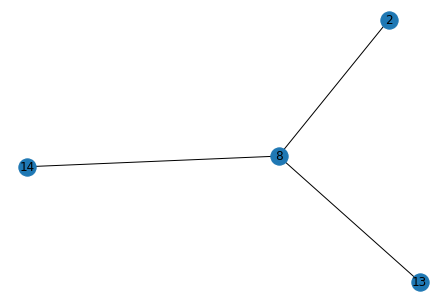

match_branches = [[2, 14]]
edges_to_delete (resolve crossover) = [[2, 8], [2, 13], [8, 13], [8, 14], [13, 14]]
edges_to_create (resolve crossover) = [[2, 14]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [0, 9], [0, 10], [9, 11], [10, 11]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 8], [2, 13], [8, 13], [8, 14], [13, 14]]
edges_to_create = [[2, 14]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 23, 27, 28, 30, 31, 33, 34, 36, 37, 40, 42, 44, 46, 47, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 71, 78, 79, 82, 83, 84, 87, 90, 91, 96, 97, 101, 102.0, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 140, 141, 147, 149, 158, 159, 160, 161, 162, 163, 164, 165, 174}
Comp 1 = {13}
Comp 2 = {133, 134, 135, 136, 137, 138, 139, 142, 143, 16, 144, 146, 145, 148, 21, 150, 151, 1

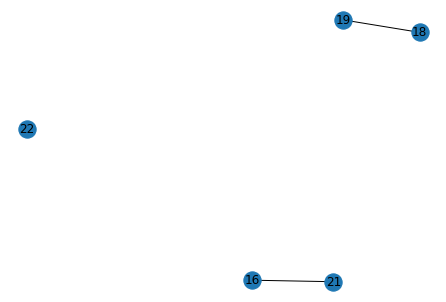

match_branches = [[18, 19], [16, 21]]
edges_to_delete (resolve crossover) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create (resolve crossover) = [[18, 19], [16, 21]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [0, 9], [0, 10], [9, 11], [10, 11], [2, 8], [2, 13], [8, 13], [8, 14], [13, 14]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create = [[18, 19], [16, 21]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 23, 27, 28, 30, 31, 33, 34, 36, 37, 40, 42, 44, 46, 47, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 71, 78, 79, 82, 83, 84, 87, 90, 91, 96, 97, 101, 102.0, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 140, 141, 147, 149, 158, 

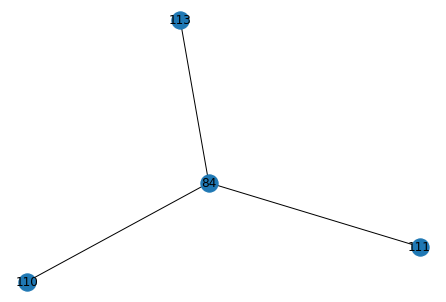

match_branches = [[110, 113]]
edges_to_delete (resolve crossover) = [[84, 110], [84, 111], [84, 113], [110, 111], [111, 113]]
edges_to_create (resolve crossover) = [[110, 113]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [0, 9], [0, 10], [9, 11], [10, 11], [2, 8], [2, 13], [8, 13], [8, 14], [13, 14], [16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[84, 110], [84, 111], [84, 113], [110, 111], [111, 113]]
edges_to_create = [[110, 113]]
Number of connected components = 6
Comp 0 = {129, 1, 3, 4, 5, 6, 7, 8, 9, 10, 140, 141, 12, 17, 18, 147, 20, 149, 19, 23, 27, 28, 158, 159, 160, 161, 162, 163, 164, 165, 33, 34, 40, 42, 44, 46, 174, 57, 58, 61, 62, 63, 64, 65, 69, 71, 79, 82, 83, 87, 90, 91, 96, 97, 101, 102.0, 104, 105, 106, 108, 109, 110, 112, 113, 114, 115, 116, 118, 119, 122, 123, 124, 125, 126}
Comp 1 = {0, 2, 68, 37, 36, 11, 14, 15, 78,

  Edge: [17 18]: curr_angle = 22.83
  Edge: [18 19]: curr_angle = 4.63
  Edge: [19 20]: curr_angle = 33.21
  Edge: [20 23]: curr_angle = 22.17
  Edge: [23 27]: curr_angle = 20.87
  Edge: [27 40]: curr_angle = 38.7
  Edge: [40 57]: curr_angle = 170.11
  Edge: [57 65]: curr_angle = 29.4
  Edge: [ 65 122]: curr_angle = 28.19
  Edge: [122 125]: curr_angle = 34.59
  Edge: [125 118]: curr_angle = 20.57
  Edge: [118 113]: curr_angle = 16.11
  Edge: [113 110]: curr_angle = 11.38

Total time for doubling_back = 1.0962255001068115
There were 1 edges that passed doubling back threshold of 100
Winning edge [40 57] had a doubling back of 170.10832297482781
***inside resolve crossover!!!!****
coordinate_branches = [40, 57, 62]
40 = red
57 = aqua
62 = purple
Angle between 40 and 57 = 157.14 
Angle between 40 and 62 = 30.18 
Angle between 57 and 62 = 22.92 
Final Matches = [[40, 62], [57, 62]]
matched_branches_revised = [[57, 62]]
Original graph


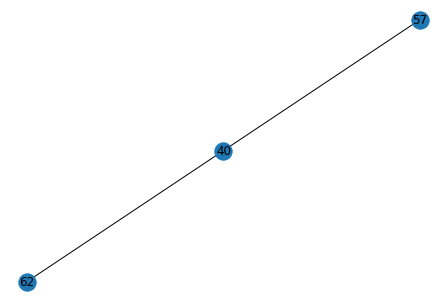

match_branches = [[57, 62]]
edges_to_delete (resolve crossover) = [[40, 57], [40, 62]]
edges_to_create (resolve crossover) = [[57, 62]]
edges_to_delete (cut_limb_network) = [array([40, 57]), array([40, 62])]
edges_to_create = [[57, 62]]
Number of connected components = 7
Comp 0 = {129, 140, 141, 147, 149, 158, 159, 160, 161, 162, 163, 164, 165, 33, 34, 44, 46, 174, 57, 58, 61, 62, 63, 64, 65, 69, 71, 79, 82, 83, 87, 90, 91, 96, 106, 108, 109, 110, 112, 113, 114, 115, 116, 118, 119, 122, 123, 124, 125, 126}
Comp 1 = {0, 2, 68, 37, 36, 11, 14, 15, 78, 47, 84, 59, 60, 30, 31}
Comp 2 = {128, 130, 131, 132, 103, 111, 127}
Comp 3 = {1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 17, 18, 19, 20, 23, 27, 28, 40, 42, 97, 101, 102.0, 104, 105}
Comp 4 = {13}
Comp 5 = {133, 134, 135, 136, 137, 138, 139, 142, 143, 16, 144, 146, 145, 148, 21, 150, 151, 152, 25, 154, 155, 26, 29, 157, 153, 32, 156, 35, 166, 39, 167, 41, 168, 43, 169, 45, 173, 171, 48, 49, 50, 51, 52, 53, 54, 55, 56, 176, 38, 66, 67, 70, 72, 73, 74,

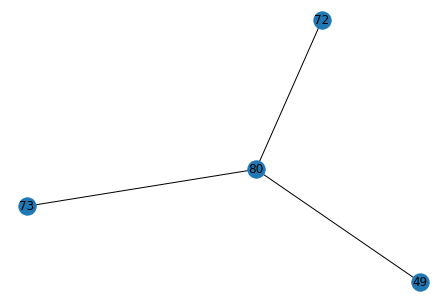

match_branches = [[49, 80]]
edges_to_delete (resolve crossover) = [[49, 72], [49, 73], [72, 73], [72, 80], [73, 80]]
edges_to_create (resolve crossover) = [[49, 80]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [0, 9], [0, 10], [9, 11], [10, 11], [2, 8], [2, 13], [8, 13], [8, 14], [13, 14], [16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [84, 110], [84, 111], [84, 113], [110, 111], [111, 113], array([40, 57]), array([40, 62])]
Skipping endnode 152 because skeletal distance was 1231.8871209716483 and threshold was 2500
skip_nodes = [152]
edges_to_delete (cut_limb_network) = [[49, 72], [49, 73], [72, 73], [72, 80], [73, 80]]
edges_to_create = [[49, 80]]
Number of connected components = 10
Comp 0 = {129, 140, 141, 147, 149, 158, 159, 160, 161, 162, 163, 164, 165, 33, 34, 44, 46, 174, 57, 58, 61, 62, 63, 64, 65, 69, 71, 79, 82, 83, 87, 90, 91, 96, 106, 108, 109, 110, 112, 113, 114, 115, 116, 118,

  Edge: [0 3]: curr_angle = 16.21
  Edge: [3 6]: curr_angle = 13.3
  Edge: [6 8]: curr_angle = 39.48
  Edge: [ 8 14]: curr_angle = 52.55
  Edge: [14 13]: curr_angle = 106.91
  Edge: [13 11]: curr_angle = 6.12
  Edge: [11 10]: curr_angle = 31.51

Total time for doubling_back = 1.211317777633667
There were 1 edges that passed doubling back threshold of 100
Winning edge [14 13] had a doubling back of 106.91115816593933
***inside resolve crossover!!!!****
coordinate_branches = [13, 14, 16]
13 = red
14 = aqua
16 = purple
Angle between 13 and 14 = 108.22 
Angle between 13 and 16 = 23.02 
Angle between 14 and 16 = 61.66 
Final Matches = [[13, 16]]
matched_branches_revised = [[13, 16]]
Original graph


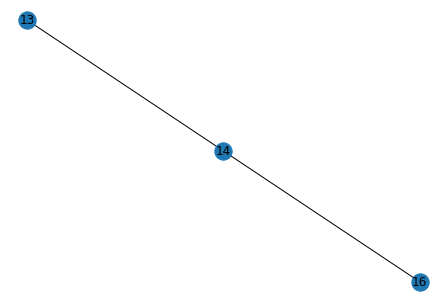

match_branches = [[13, 16]]
edges_to_delete (resolve crossover) = [[13, 14], [14, 16]]
edges_to_create (resolve crossover) = [[13, 16]]
edges_to_delete (cut_limb_network) = [array([13, 14]), array([14, 16])]
edges_to_create = [[13, 16]]
Number of connected components = 2
Comp 0 = {0, 2, 3, 5, 6, 7, 8, 14, 15}
Comp 1 = {1, 4, 9, 10, 11, 12, 13, 16}
curr_limb_copy.deleted_edges = [array([13, 14]), array([14, 16])]
curr_limb_copy.created_edges = [[13, 16]]
After get best cut: cut_edges = [array([13, 14]), array([14, 16])], added_edges = [[13, 16]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  2,  3,  5,  6,  7,  8, 14, 15]), array([ 1,  4,  9, 10, 11, 12, 13, 16])]


 ------ Total time for Splitting 864691

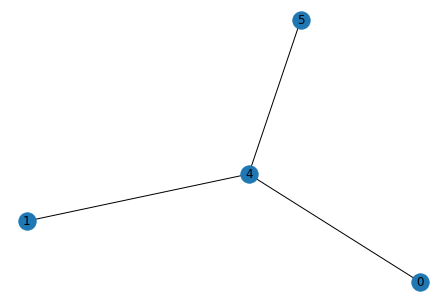

match_branches = [[0, 5]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 4], [1, 4], [1, 5], [4, 5]]
edges_to_create (resolve crossover) = [[0, 5]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 4], [1, 4], [1, 5], [4, 5]]
edges_to_create = [[0, 5]]
Number of connected components = 4
Comp 0 = {0, 2, 5, 6, 7, 8, 11, 12, 13}
Comp 1 = {1}
Comp 2 = {9, 10, 4}
Comp 3 = {3}
curr_limb_copy.deleted_edges = [[0, 1], [0, 4], [1, 4], [1, 5], [4, 5]]
curr_limb_copy.created_edges = [[0, 5]]
After get best cut: cut_edges = [[0, 1], [0, 4], [1, 4], [1, 5], [4, 5]], added_edges = [[0, 5]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 4: [array([ 0,  2,  5,  6,  7,  8, 11, 12, 13]), 

  Edge: [3 4]: curr_angle = 35.99
  Edge: [4 5]: curr_angle = 22.81
  Edge: [ 5 10]: curr_angle = 141.87
  Edge: [10  8]: curr_angle = 20.07

Total time for doubling_back = 0.5614039897918701
There were 1 edges that passed doubling back threshold of 100
Winning edge [ 5 10] had a doubling back of 141.87429338395833
***inside resolve crossover!!!!****
coordinate_branches = [5, 10, 11]
5 = red
10 = aqua
11 = purple
Angle between 5 and 10 = 154.85 
Angle between 5 and 11 = 9.84 
Angle between 10 and 11 = 25.91 
Final Matches = [[5, 11], [10, 11]]
matched_branches_revised = [[5, 11]]
Original graph


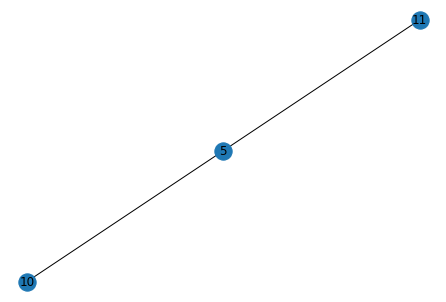

match_branches = [[5, 11]]
edges_to_delete (resolve crossover) = [[5, 10], [10, 11]]
edges_to_create (resolve crossover) = [[5, 11]]
edges_to_delete (cut_limb_network) = [array([ 5, 10]), array([10, 11])]
edges_to_create = [[5, 11]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 11, 12}
Comp 1 = {8, 9, 10}
curr_limb_copy.deleted_edges = [array([ 5, 10]), array([10, 11])]
curr_limb_copy.created_edges = [[5, 11]]
After get best cut: cut_edges = [array([ 5, 10]), array([10, 11])], added_edges = [[5, 11]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  5,  6,  7, 11, 12]), array([ 8,  9, 10])]


 ------ Total time for Splitting 864691135725648447 = 92.49566888809204 -----

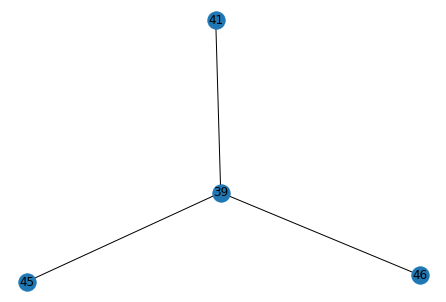

match_branches = [[39, 46]]
edges_to_delete (resolve crossover) = [[39, 41], [39, 45], [41, 45], [41, 46], [45, 46]]
edges_to_create (resolve crossover) = [[39, 46]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[39, 41], [39, 45], [41, 45], [41, 46], [45, 46]]
edges_to_create = [[39, 46]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
Comp 1 = {41}
Comp 2 = {45}
Comp 3 = {42}
curr_limb_copy.deleted_edges = [[39, 41], [39, 45], [41, 45], [41, 46], [45, 46]]
curr_limb_copy.created_edges = [[39, 46]]
After get best cut: cut_edges = [[39, 41], [39, 45], [41, 45], [41, 46], [45,

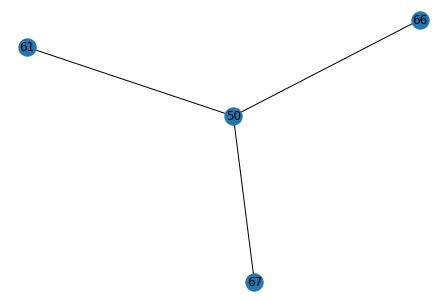

match_branches = [[61, 66], [50, 67]]
edges_to_delete (resolve crossover) = [[50, 61], [50, 66], [61, 67], [66, 67]]
edges_to_create (resolve crossover) = [[61, 66], [50, 67]]
curr_limb.deleted_edges 5 =[[39, 41], [39, 45], [41, 45], [41, 46], [45, 46]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[50, 61], [50, 66], [61, 67], [66, 67]]
edges_to_create = [[61, 66], [50, 67]]
Number of connected components = 5
Comp 0 = {32, 64, 65, 67, 68, 69, 70, 39, 40, 72, 71, 46, 49, 50, 54, 55, 56, 57, 58, 63}
Comp 1 = {41}
Comp 2 = {45}
Comp 3 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 43, 44, 47, 48, 51, 52, 53, 59, 60, 61, 62, 66, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
Comp 4 = {42}
curr_limb_copy.deleted_edges = [[39, 41], [39, 45], [41, 45], [41, 46], [45, 46], [50, 61], [50, 66], [61, 67], [66, 67]]
curr_limb_c

  Edge: [27 29]: curr_angle = 55.58
  Edge: [29 25]: curr_angle = 91.19
  Edge: [25 24]: curr_angle = 11.83
  Edge: [24 18]: curr_angle = 29.38
  Edge: [18 16]: curr_angle = 16.8
  Edge: [16 17]: curr_angle = 12.59
  Edge: [17 14]: curr_angle = 28.22
  Edge: [14 15]: curr_angle = 20.15
  Edge: [15 23]: curr_angle = 1.32
  Edge: [23 20]: curr_angle = 27.53
  Edge: [20 47]: curr_angle = 30.61
  Edge: [47 62]: curr_angle = 48.57
  Edge: [62 75]: curr_angle = 8.12
  Edge: [75 78]: curr_angle = 10.67
  Edge: [78 80]: curr_angle = 12.05
  Edge: [80 82]: curr_angle = 28.08
  Edge: [82 84]: curr_angle = 29.01

Total time for doubling_back = 2.842590570449829

Attempting the width jump check (attempting from both sides)
  Edge: [27 29]: jump = -535.63
  Edge: [29 25]: jump = 371.44
Adding error edge [29 25] because width jump was 371.4449538661925
  Edge: [25 24]: jump = -80.58
  Edge: [24 18]: jump = 7.89
  Edge: [18 16]: jump = -75.58
  Edge: [16 17]: jump = -58.53
  Edge: [17 14]: jump = -40

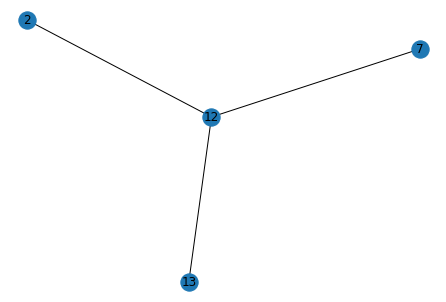

match_branches = [[2, 12]]
edges_to_delete (resolve crossover) = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
edges_to_create (resolve crossover) = [[2, 12]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
edges_to_create = [[2, 12]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 27, 28, 33, 34, 36, 37, 48, 49, 63, 67, 69, 70, 71, 72}
Comp 1 = {7}
Comp 2 = {4, 10, 13, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
curr_limb_copy.created_edges = [[2, 12]]
After get best cut: cut_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]], added_edges = [[2, 12]]
total_soma_paths_to_cut = []
-----------counter = 0-

  Edge: [37 34]: curr_angle = 68.74
  Edge: [34 28]: curr_angle = 54.36
  Edge: [28 33]: curr_angle = 15.22
  Edge: [33 63]: curr_angle = 43.94

Total time for doubling_back = 0.24875855445861816

Attempting the width jump check (attempting from both sides)
  Edge: [37 34]: jump = -217.36
  Edge: [34 28]: jump = 131.05
  Edge: [28 33]: jump = -87.82
  Edge: [33 63]: jump = 120.02
Total time for width = 0.34125638008117676
Path starting at 37 had err_edges: []
  Edge: [63 33]: jump = -120.02
  Edge: [33 28]: jump = 87.82


----- Working on Neuron 864691135403709422-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [0]
multi_touch_limbs = []


 -------- Working on limb 0------------
Starting combinations to process = [[ 0 10]]


---- working on disconnecting 0 and 10
---- This disconnects S1_0 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL

  Edge: [0 1]: curr_angle = 43.35
  Edge: [1 8]: curr_angle = 46.36
  Edge: [8 7]: curr_angle = 79.51
  Edge: [ 7 11]: curr_angle = 36.22
  Edge: [11 10]: curr_angle = 47.63

Total time for doubling_back = 0.9638192653656006

Attempting the width jump check (attempting from both sides)
  Edge: [0 1]: jump = -148.12
  Edge: [1 8]: jump = 162.55
  Edge: [8 7]: jump = 96.16
  Edge: [ 7 11]: jump = 149.11
  Edge: [11 10]: jump = 294.44
Adding error edge [11 10] because width jump was 294.4381743139495
Total time for width = 1.7275736331939697
Path starting at 0 had err_edges: [[11, 10]]
  Edge: [10 11]: jump = -294.44
  Edge: [11  7]: jump = -149.11
  Edge: [7 8]: jump = 124.16
  Edge: [8 1]: jump = -84.1
  Edge: [1 0]: jump = 148.12
Total time for width = 0.8964824676513672
Path starting at 10 had err_edges: []
first_error_sizes = [294.4381743139495, -inf], winning_path = 0
***inside resolve crossover!!!!****
coordinate_branches = [10, 11, 13]
10 = red
11 = aqua
13 = purple
Angle between 

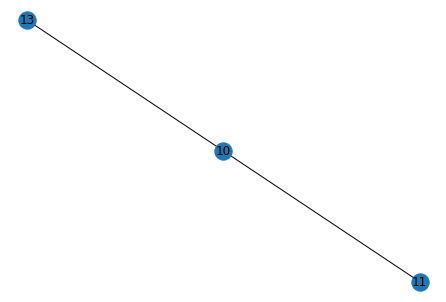

match_branches = []
edges_to_delete (resolve crossover) = [[10, 11], [10, 13], [11, 13]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([10, 11]), array([10, 13]), array([11, 13])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {10}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62}
Comp 2 = {40, 41, 13, 14, 15, 51, 52}
curr_limb_copy.deleted_edges = [array([10, 11]), array([10, 13]), array([11, 13])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([10, 11]), array([10, 13]), array([11, 13])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path 

  Edge: [15 16]: curr_angle = 61.76
  Edge: [16 18]: curr_angle = 139.24
  Edge: [18 22]: curr_angle = 138.94
  Edge: [22 21]: curr_angle = 165.82
  Edge: [21 23]: curr_angle = 33.32
  Edge: [23 24]: curr_angle = 176.79

Total time for doubling_back = 0.15215373039245605
There were 4 edges that passed doubling back threshold of 100
Winning edge [23 24] had a doubling back of 176.78574386128113
***inside resolve crossover!!!!****
coordinate_branches = [17, 23, 24]
17 = red
23 = aqua
24 = purple
Angle between 17 and 23 = 82.62 
Angle between 17 and 24 = 58.83 
Angle between 23 and 24 = 45.8 
Final Matches = []
matched_branches_revised = []
Original graph


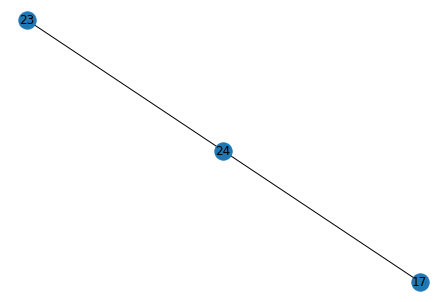

match_branches = []
edges_to_delete (resolve crossover) = [[17, 23], [17, 24], [23, 24]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([17, 23]), array([17, 24]), array([23, 24])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28}
Comp 1 = {17, 12, 6}
Comp 2 = {24}
curr_limb_copy.deleted_edges = [array([17, 23]), array([17, 24]), array([23, 24])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([17, 23]), array([17, 24]), array([23, 24])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 1

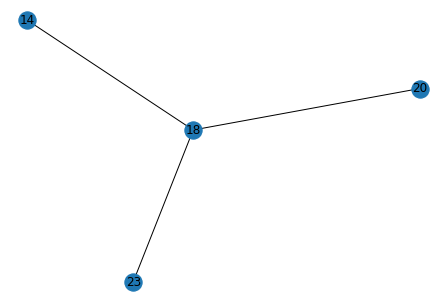

match_branches = [[14, 18], [20, 23]]
edges_to_delete (resolve crossover) = [[14, 20], [14, 23], [18, 20], [18, 23]]
edges_to_create (resolve crossover) = [[14, 18], [20, 23]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[14, 20], [14, 23], [18, 20], [18, 23]]
edges_to_create = [[14, 18], [20, 23]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48}
Comp 1 = {49}
curr_limb_copy.deleted_edges = [[14, 20], [14, 23], [18, 20], [18, 23]]
curr_limb_copy.created_edges = [[14, 18], [20, 23]]
After get best cut: cut_edges = [[14, 20], [14, 23], [18, 20], [18, 23]], added_edges = [[14, 18], [20, 23]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the en

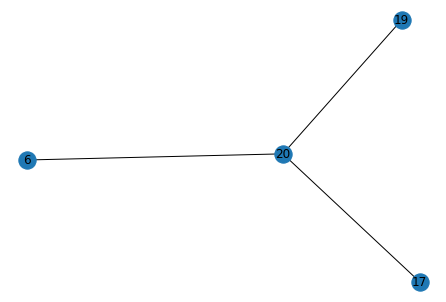

match_branches = [[6, 17]]
edges_to_delete (resolve crossover) = [[6, 19], [6, 20], [17, 19], [17, 20], [19, 20]]
edges_to_create (resolve crossover) = [[6, 17]]
curr_limb.deleted_edges 5 =[[14, 20], [14, 23], [18, 20], [18, 23]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[6, 19], [6, 20], [17, 19], [17, 20], [19, 20]]
edges_to_create = [[6, 17]]
Number of connected components = 5
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 22, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
Comp 1 = {0, 12, 47, 48, 20, 23, 24, 25, 27, 28, 29, 30}
Comp 2 = {19}
Comp 3 = {21}
Comp 4 = {49}
curr_limb_copy.deleted_edges = [[14, 20], [14, 23], [18, 20], [18, 23], [6, 19], [6, 20], [17, 19], [17, 20], [19, 20]]
curr_limb_copy.created_edges = [[14, 18], [20, 23], [6, 17]]
After get best cut: cut_edges = [[6, 19], [6, 20], [17, 19], [17, 20], [19, 20]], added_edges = [[6, 17]]
total_soma_paths_to_cut = [[14, 20], [14, 23], [18, 20], [18, 23]]
-----------

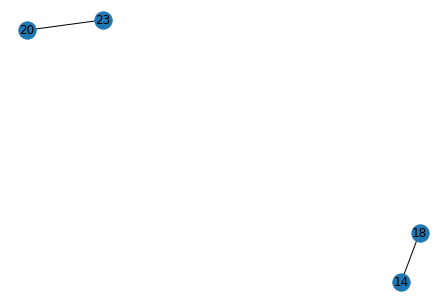

match_branches = [[14, 18], [20, 23]]
edges_to_delete (resolve crossover) = [[14, 20], [14, 23], [18, 20], [18, 23]]
edges_to_create (resolve crossover) = [[14, 18], [20, 23]]
curr_limb.deleted_edges 5 =[[14, 20], [14, 23], [18, 20], [18, 23], [6, 19], [6, 20], [17, 19], [17, 20], [19, 20]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[14, 20], [14, 23], [18, 20], [18, 23]]
edges_to_create = [[14, 18], [20, 23]]
Number of connected components = 5
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 22, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
Comp 1 = {0, 12, 47, 48, 20, 23, 24, 25, 27, 28, 29, 30}
Comp 2 = {19}
Comp 3 = {21}
Comp 4 = {49}
curr_limb_copy.deleted_edges = [[14, 20], [14, 23], [18, 20], [18, 23], [6, 19], [6, 20], [17, 19], [17, 20], [19, 20], [14, 20], [14, 23], [18, 20], [18, 23]]
curr_limb_copy.created_edges = [[14, 18], [20, 23], [6, 17], [14, 18], [20, 23]]
After get best cut: cut_edges = [[14, 20], [14, 23], [18, 2

  Edge: [8 9]: curr_angle = 32.47
  Edge: [ 9 11]: curr_angle = 2.13
  Edge: [11 18]: curr_angle = 80.69
  Edge: [18 14]: curr_angle = 4.13
  Edge: [14 15]: curr_angle = 43.42
  Edge: [15 22]: curr_angle = 118.12
  Edge: [22 41]: curr_angle = 41.79
  Edge: [41 34]: curr_angle = 40.18
  Edge: [34 35]: curr_angle = 17.59
  Edge: [35 32]: curr_angle = 28.02

Total time for doubling_back = 0.6855320930480957
There were 1 edges that passed doubling back threshold of 100
Winning edge [15 22] had a doubling back of 118.11591447198468
***inside resolve crossover!!!!****
coordinate_branches = [15, 17, 22]
15 = red
17 = aqua
22 = purple
Angle between 15 and 17 = 107.36 
Angle between 15 and 22 = 88.66 
Angle between 17 and 22 = 17.04 
Final Matches = [[17, 22]]
matched_branches_revised = [[17, 22]]
Original graph


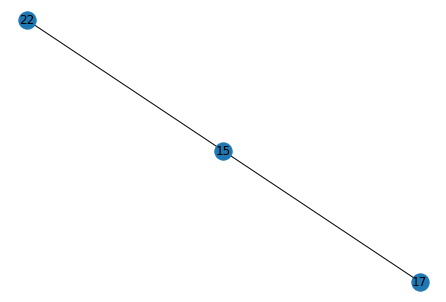

match_branches = [[17, 22]]
edges_to_delete (resolve crossover) = [[15, 17], [15, 22]]
edges_to_create (resolve crossover) = [[17, 22]]
edges_to_delete (cut_limb_network) = [array([15, 17]), array([15, 22])]
edges_to_create = [[17, 22]]
Number of connected components = 6
Comp 0 = {1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18}
Comp 1 = {0, 12, 47, 48, 20, 23, 24, 25, 27, 28, 29, 30}
Comp 2 = {3, 6, 17, 22, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
Comp 3 = {19}
Comp 4 = {21}
Comp 5 = {49}
curr_limb_copy.deleted_edges = [[14, 20], [14, 23], [18, 20], [18, 23], [6, 19], [6, 20], [17, 19], [17, 20], [19, 20], [14, 20], [14, 23], [18, 20], [18, 23], array([15, 17]), array([15, 22])]
curr_limb_copy.created_edges = [[14, 18], [20, 23], [6, 17], [14, 18], [20, 23], [17, 22]]
After get best cut: cut_edges = [array([15, 17]), array([15, 22])], added_edges = [[17, 22]]
total_soma_paths_to_cut = [[14, 20], [14, 23], [18, 20], [18, 23]]
-----------counter = 1-----------

  Edge: [32 36]: curr_angle = 57.35
  Edge: [36 43]: curr_angle = 24.4
  Edge: [43 45]: curr_angle = 150.12
  Edge: [45 40]: curr_angle = 153.41
  Edge: [40 33]: curr_angle = 27.68

Total time for doubling_back = 0.2632021903991699
There were 2 edges that passed doubling back threshold of 100
Winning edge [45 40] had a doubling back of 153.4067050938305
***inside resolve crossover!!!!****
coordinate_branches = [40, 45, 46]
40 = red
45 = aqua
46 = purple
Angle between 40 and 45 = 43.52 
Angle between 40 and 46 = 28.07 
Angle between 45 and 46 = 160.56 
Final Matches = [[40, 46]]
matched_branches_revised = [[40, 46]]
Original graph


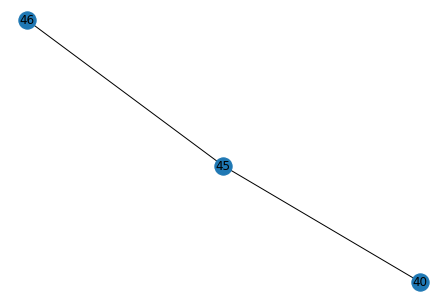

match_branches = [[40, 46]]
edges_to_delete (resolve crossover) = [[40, 45], [45, 46]]
edges_to_create (resolve crossover) = [[40, 46]]
edges_to_delete (cut_limb_network) = [array([40, 45]), array([45, 46])]
edges_to_create = [[40, 46]]
Number of connected components = 7
Comp 0 = {1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18}
Comp 1 = {0, 12, 47, 48, 20, 23, 24, 25, 27, 28, 29, 30}
Comp 2 = {32, 34, 3, 35, 36, 6, 38, 41, 42, 43, 44, 45, 17, 22, 31}
Comp 3 = {19}
Comp 4 = {33, 37, 39, 40, 46, 26}
Comp 5 = {21}
Comp 6 = {49}
curr_limb_copy.deleted_edges = [[14, 20], [14, 23], [18, 20], [18, 23], [6, 19], [6, 20], [17, 19], [17, 20], [19, 20], [14, 20], [14, 23], [18, 20], [18, 23], array([15, 17]), array([15, 22]), array([40, 45]), array([45, 46])]
curr_limb_copy.created_edges = [[14, 18], [20, 23], [6, 17], [14, 18], [20, 23], [17, 22], [40, 46]]
After get best cut: cut_edges = [array([40, 45]), array([45, 46])], added_edges = [[40, 46]]
total_soma_paths_to_cut = []
-----------counte

In [ ]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")